# Tutorial: explain a tabular classifier through LORE

LORE provides interpretable explanations for the decisions made by machine learning models, particularly in situations where it might be challenging to explain the model's behavior using traditional methods. LORE is designed to offer explanations on a per-instance basis, meaning it provides insights into why a specific prediction was made for a particular data point. This is in contrast to global explanations that aim to provide an overview of a model's behavior across the entire dataset.


In this tutorial we will explain the reasoning of a random forest classifier when applied to an instance of the Adult Income dataset ( https://archive.ics.uci.edu/dataset/2/adult). This dataset contains census data from 1994 census database, the classification problem associated to such data involves the prediction of the annual income of a person, given a set of socio-economic caracteristics: 
- working class
- marital status
- occupation
- relationship
- race
- sex
- capital gain/loss
- native country 





### Dataset loading 

Lore libray has a module devoted to dataset handling. Here we use TabularDataset class to load a dataset from a csv file. A TabularDataset has a column that represent the target class (`class_name`) of the classification task  object, and has two main attributes: 
- `df` : a pandas dataframe representing the tabular data
- `descriptor` : a dictionary containing internal data related to the dataset. It is build when a TabularDataset is created, but it could also be edited. It is used by the next steps of LORE methodology to distinguish among numerical, categorical, ordinal and target features of the dataset.

In [8]:
from lore_sa.dataset import TabularDataset
import pandas as pd

# Cargar el dataset y limpiar espacios en los nombres de columnas
df = pd.read_csv('test/resources/adult.csv')
df.columns = df.columns.str.strip()  # Elimina espacios en los nombres de las columnas

# Asegurar que cada clase tiene exactamente 5 muestras (o todas las que existan si hay menos de 5)
df_small = df.groupby("class", group_keys=False).apply(lambda x: x.sample(n=11, random_state=42)).reset_index(drop=True)

# Guardar el nuevo dataset reducido
df_small.to_csv('test/resources/adult_small.csv', index=False)

# adult.csv --> dataset completo
# adult_small.csv --> dataset reducido

dataset = TabularDataset.from_csv('test/resources/adult_small.csv', class_name="class")

# Mostrar la distribución de clases en el dataset reducido
print(dataset.df["class"].value_counts())


dataset.df  # Mostrar el dataset reducido


2025-07-09 09:38:25,298 root         INFO     test/resources/adult_small.csv file imported


class
>50K     11
<=50K     9
Name: count, dtype: int64


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,32,Private,43403,Some-college,10,Divorced,Farming-fishing,Not-in-family,White,Female,0,1590,54,United-States,<=50K
2,51,Private,332243,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,45,United-States,<=50K
3,27,Private,158156,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,42,United-States,<=50K
4,64,Self-emp-not-inc,170421,Some-college,10,Widowed,Craft-repair,Not-in-family,White,Female,0,0,8,United-States,<=50K
6,53,Private,152657,10th,6,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,<=50K
7,50,Federal-gov,299831,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,880,40,United-States,<=50K
8,38,Private,149419,Assoc-voc,11,Never-married,Tech-support,Not-in-family,White,Male,0,0,50,United-States,<=50K
9,34,Private,224358,10th,6,Never-married,Other-service,Unmarried,Black,Female,0,0,40,United-States,<=50K
10,39,Private,205359,Assoc-acdm,12,Widowed,Adm-clerical,Unmarried,White,Female,0,0,45,United-States,<=50K
11,38,Private,233194,HS-grad,9,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States,>50K


The `TabularDataset` class does some data inspection and preparation when it is created starting from a text-based file. Each attribute of the data is analysed to derive type and internal statistics. The `descriptor` field is automatically updates with these information. In particular, the `descriptor` is a dictionary that contains the following keys:
- `numerical` : a dictionary containing the numerical features of the dataset and their statistics
- `categorical` : a dictionary containing the categorical features of the dataset and their statistics
- `ordinal` : (this is still not implemented) a dictionary containing the ordinal features of the dataset and their statistics
- `target` : the details of the target feature of the dataset and its statistics  

In [9]:
dataset.descriptor.keys()

dict_keys(['numeric', 'categorical', 'ordinal', 'target'])

Before proceeding with the explanation, let's do some data preprocessing by dropping a few attributes that are not relevant for the learning. 

We operate directly on the `df` attribute of the dataset, then we update the descriptor.


In [10]:
dataset.df.drop(['fnlwgt', 'education-num','capital-gain','capital-loss'], inplace=True, axis=1)
dataset.update_descriptor()

feature_names = list(dataset.descriptor["numeric"].keys()) + list(dataset.descriptor["categorical"].keys())
class_names = dataset.df["class"].unique().tolist()

dataset.df[:5]

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,class
0,32,Private,Some-college,Divorced,Farming-fishing,Not-in-family,White,Female,54,United-States,<=50K
2,51,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Male,45,United-States,<=50K
3,27,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Female,42,United-States,<=50K
4,64,Self-emp-not-inc,Some-college,Widowed,Craft-repair,Not-in-family,White,Female,8,United-States,<=50K
6,53,Private,10th,Married-civ-spouse,Craft-repair,Husband,Black,Male,40,United-States,<=50K


In [11]:
print(feature_names)
print(class_names)

['age', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
['<=50K', '>50K']


## Model Learning

We start by training a Random Forest classifier on the Adult dataset. We will use the `df` attribute of the dataset, which is a pandas dataframe containing the tabular data. We will use the `class_name` attribute of the dataset to identify the target feature of the classification task. Since the data contains non-numeric attributes, we proceed with a preprocessing of the data to mange these attributes. We will exploit `Pipeline` class from `sklearn` to create a pipeline that applies one-hot encoding to the categorical features and label encoding to the target feature. 

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from lore_sa.bbox import sklearn_classifier_bbox
from sklearn.tree import DecisionTreeClassifier

# Extraer columnas del descriptor
numeric_features = list(dataset.descriptor["numeric"].keys())
categorical_features = list(dataset.descriptor["categorical"].keys())

# Función para obtener nombres de columnas transformadas
def get_feature_names_from_column_transformer(preprocessor):
    output_features = []

    for name, trans, cols in preprocessor.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out()
            # Si devuelve algo como 'num__age', quita el prefijo
            names = [n.split('__')[-1] for n in names]
        else:
            names = cols
        output_features.extend(names)

    return output_features

# Función para entrenar modelo
def train_model(dataset):
    # Índices según posición en el DataFrame
    num_indices = [0, 8]  # 'age', 'hours-per-week'
    cat_indices = [1, 2, 3, 4, 5, 6, 9]  # resto de columnas

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_indices),
            ('cat', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_indices)
        ]
    )

    model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3, random_state=42))

    # Entrenamiento
    X = dataset.df.loc[:, 'age':'native-country'].values
    y = dataset.df['class'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )


    model.fit(X_train, y_train)


    feature_names = get_feature_names_from_column_transformer(preprocessor)

    return sklearn_classifier_bbox.sklearnBBox(model), X_train, y_train, X_test, y_test, feature_names


In [13]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.experimental import enable_halving_search_cv
from lore_sa.lore import TabularRandomGeneratorLore

bbox, X_train, y_train, X_test, y_test, _  = train_model(dataset)

# # Obtener predicciones en el conjunto de prueba
y_pred = bbox.bbox.predict(X_test)

# Imprimir métricas
print("🔍 Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))
print(f" Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

🔍 Reporte de clasificación:

              precision    recall  f1-score   support

       <=50K       1.00      0.25      0.40         4
        >50K       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8

 Precisión del modelo: 0.62


## Explanation

Given the blackbox model, we can now explain the reasoning behind the classification of a specific instance. We will use the `LORE` class to explain the classification of the first instance of the dataset. The `explain_instance` method of the `LORE` class takes as input the instance to be explained, the blackbox model, and the dataset. It returns an explanation object that contains the explanation of the classification of the instance.

The constructor of the explanator class takes as input the blackbox model and the dataset. The `dataset` instance is used to get the information from the descriptor. In case the trainin set is not available, the descriptor could be built from the test set or by the metadata of the dataset.

In [14]:
from lore_sa.lore import TabularRandomGeneratorLore
from lore_sa.lore import TabularGeneticGeneratorLore

print("dataset.df")
print(dataset.df)

tabularLore_small = TabularGeneticGeneratorLore(bbox, dataset)

print("tabularLore_small")
print(tabularLore_small)
# Elegir una instancia para explicar
num_row = 5  # Puedes cambiar el índice para probar distintas instancias
x = dataset.df.iloc[num_row][:-1]

print("x")
print(x)

# Generar explicación
explanation_small = tabularLore_small.explain(x)

dataset.df
    age         workclass     education      marital-status       occupation  \
0    32           Private  Some-college            Divorced  Farming-fishing   
2    51           Private     Bachelors            Divorced   Prof-specialty   
3    27           Private       HS-grad       Never-married    Other-service   
4    64  Self-emp-not-inc  Some-college             Widowed     Craft-repair   
6    53           Private          10th  Married-civ-spouse     Craft-repair   
7    50       Federal-gov  Some-college            Divorced     Adm-clerical   
8    38           Private     Assoc-voc       Never-married     Tech-support   
9    34           Private          10th       Never-married    Other-service   
10   39           Private    Assoc-acdm             Widowed     Adm-clerical   
11   38           Private       HS-grad  Married-civ-spouse            Sales   
12   58           Private     Bachelors  Married-civ-spouse  Exec-managerial   
13   56      Self-emp-inc  So

In [8]:
from IPython.display import Image
import numpy as np

def visualize_supertree(tree, feature_names=None, class_names=None):
    from graphviz import Digraph
    import re

    dot = Digraph()
    node_id = [0]

    def base_name(feat):
        # Si es de tipo "occupation=Sales" → devuelve "occupation"
        return feat.split('=')[0] if '=' in feat else feat

    def add_node(node, parent_id=None, edge_label=''):
        curr_id = str(node_id[0])
        node_id[0] += 1

        if node.is_leaf:
            class_index = np.argmax(node.labels)
            class_label = class_names[class_index] if class_names else f"class {class_index}"
            label = f"class: {class_label}\n{node.labels}"
        else:
            # Nombre del atributo (ya en texto plano)
            try:
                fname = feature_names[node.feat]
                label = base_name(fname)
            except:
                label = f"X_{node.feat}"

        dot.node(curr_id, label)

        if parent_id is not None:
            dot.edge(parent_id, curr_id, label=edge_label)

        if not node.is_leaf:
            for i, child in enumerate(node.children):
                try:
                    feat_val = feature_names[node.feat]
                except:
                    feat_val = f"X_{node.feat}"

                # Si categórico (hay =) → mostrar comparación clara
                if '=' in feat_val:
                    attr, val = feat_val.split('=')
                    if i == 0:
                        edge = f"≠ {val}"  # izquierda
                    else:
                        edge = f"= {val}"  # derecha
                else:
                    # Numérica
                    if i == 0:
                        edge = f"<= {node.intervals[i]:.2f}"
                    else:
                        edge = f"> {node.intervals[i - 1]:.2f}"

                add_node(child, curr_id, edge)

    add_node(tree)
    return dot

2025-07-04 09:18:35,888 matplotlib   DEBUG    matplotlib data path: c:\Users\pablo\anaconda3\Lib\site-packages\matplotlib\mpl-data
2025-07-04 09:18:35,903 matplotlib   DEBUG    CONFIGDIR=C:\Users\pablo\.matplotlib
2025-07-04 09:18:36,137 matplotlib   DEBUG    interactive is False
2025-07-04 09:18:36,137 matplotlib   DEBUG    platform is win32
2025-07-04 09:18:36,219 matplotlib   DEBUG    CACHEDIR=C:\Users\pablo\.matplotlib
2025-07-04 09:18:36,222 matplotlib.font_manager DEBUG    Using fontManager instance from C:\Users\pablo\.matplotlib\fontlist-v390.json
2025-07-04 09:18:36,492 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-04 09:18:36,492 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-04 09:18:36,492 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-04 09:18:36,492 matplotl

['age', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'education=10th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=HS-grad', 'education=Masters', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-civ-spouse', 'marital-status=Never-married', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Other-service', 'occupation=Prof-specialty', 'occupation=Protective-serv', 'occupation=Sales', 'occupation=Tech-support', 'relationship=Husband', 'relationship=Not-in-family', 'relationship=Unmarried', 'relationship=Wife', 'race=Black', 'race=White', 'sex=Female', 'sex=Male', 'native-country=Canada', 'native-country=United-States']
|--- relationship=Unmarried <= 0.50
|   |--- class: 1
|--- relationship=Unmarried >  0.50
|   |--- class: 0



2025-07-04 09:18:36,674 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-07-04 09:18:36,675 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTAUR.TTF', name='Centaur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-04 09:18:36,675 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-04 09:18:36,675 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-07-04 09:18:36,676 matplotlib.font_manager DEBUG    findfon

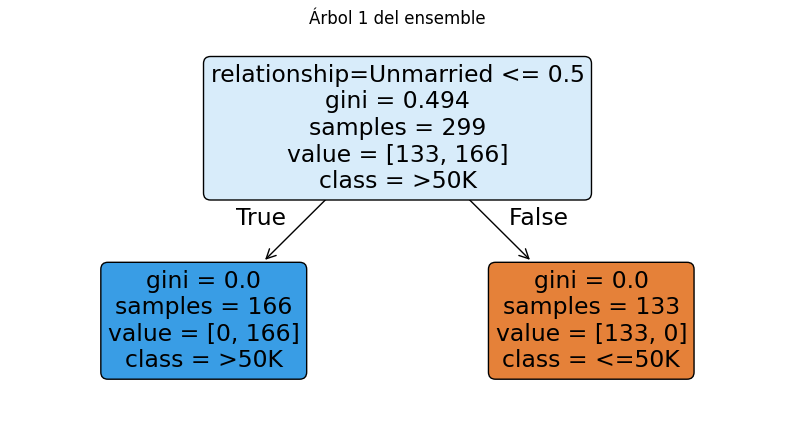

|--- relationship=Unmarried <= 0.50
|   |--- class: 1
|--- relationship=Unmarried >  0.50
|   |--- class: 0



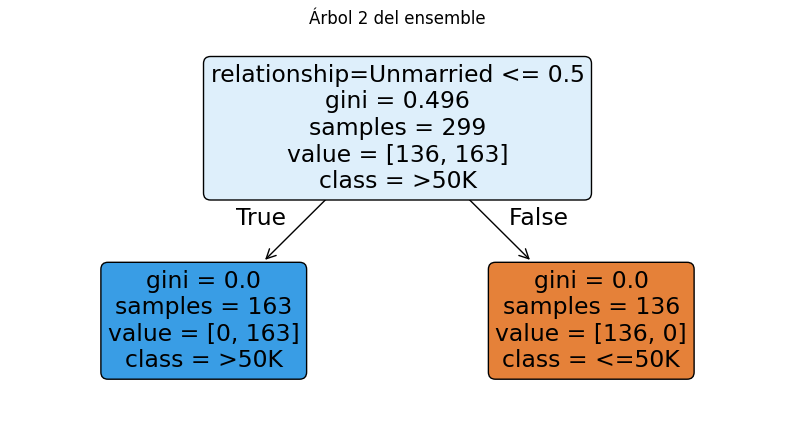

|--- relationship=Unmarried <= 0.50
|   |--- class: 1
|--- relationship=Unmarried >  0.50
|   |--- class: 0



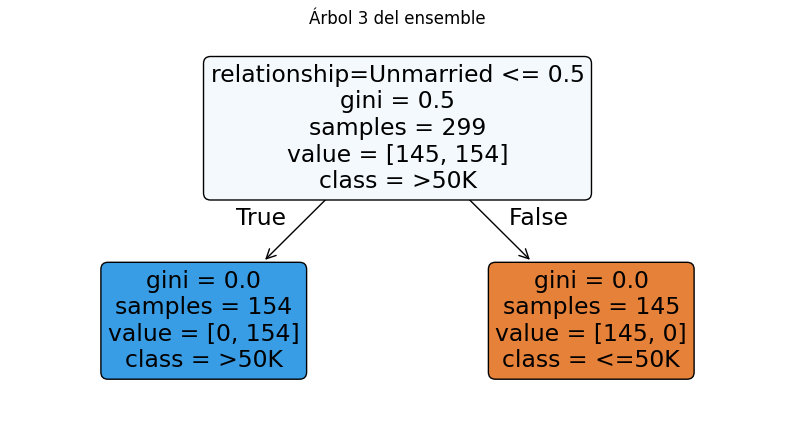

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

ensemble = tabularLore_small.surrogate  # ya está entrenado internamente
feature_names = list(tabularLore_small.encoder.encoded_features.values())

print(feature_names)

# Dibujar cada árbol individual
for i, tree in enumerate(ensemble.trees):
    print(export_text(tree, feature_names=feature_names))
    plt.figure(figsize=(10, 5))
    plot_tree(tree, filled=True, rounded=True, 
              feature_names=feature_names, 
              class_names=class_names)
    plt.title(f"Árbol {i+1} del ensemble")
    plt.show()

2025-07-04 09:18:37,827 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-07-04 09:18:37,831 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-07-04 09:18:37,834 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-07-04 09:18:37,836 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2025-07-04 09:18:37,840 graphviz._tools DEBUG    deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
2025-07-04 09:18:37,841 graphviz._tools DEBUG    deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2025-07-04 09:18:37,842 graphviz._tools DEBUG    deprecate positi

[{'is_leaf': False, 'labels': [0.44481605351170567, 0.5551839464882943], 'feat': 29, 'thresh': 0.5, 'left': {'is_leaf': True, 'labels': [0.0, 1.0], 'feat': None, 'thresh': None}, 'right': {'is_leaf': True, 'labels': [1.0, 0.0], 'feat': None, 'thresh': None}}, {'is_leaf': False, 'labels': [0.45484949832775917, 0.5451505016722408], 'feat': 29, 'thresh': 0.5, 'left': {'is_leaf': True, 'labels': [0.0, 1.0], 'feat': None, 'thresh': None}, 'right': {'is_leaf': True, 'labels': [1.0, 0.0], 'feat': None, 'thresh': None}}, {'is_leaf': False, 'labels': [0.48494983277591974, 0.5150501672240803], 'feat': 29, 'thresh': 0.5, 'left': {'is_leaf': True, 'labels': [0.0, 1.0], 'feat': None, 'thresh': None}, 'right': {'is_leaf': True, 'labels': [1.0, 0.0], 'feat': None, 'thresh': None}}]
Feature[29] split:
  ├─ If <= 0.50:
    Leaf → pred: [0. 3.]
  ├─ If > 0.50:
    Leaf → pred: [3. 0.]



2025-07-04 09:18:37,894 graphviz.rendering DEBUG    delete 'supertree_unpruned'


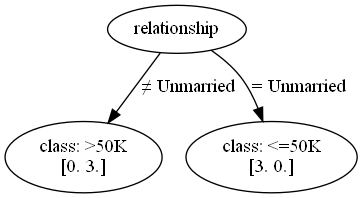

In [10]:
# Guardar también el árbol sin podar
from lore_sa.surrogate.decision_tree import SuperTree


ensemble = tabularLore_small.surrogate  # ya está entrenado internamente
unpruned_tree = SuperTree()
roots = [unpruned_tree.rec_buildTree(tree, list(range(tree.n_features_in_)), num_classes=ensemble.trees[0].n_classes_) for tree in ensemble.trees]

print(roots)
unpruned_tree.mergeDecisionTrees(roots, num_classes=ensemble.trees[0].n_classes_)

print(unpruned_tree)


feature_names = list(tabularLore_small.encoder.encoded_features.values())



# Guardar dentro de explanation_small
explanation_small["unpruned_tree"] = unpruned_tree



visualize_supertree(
    explanation_small["unpruned_tree"].root,
    feature_names=feature_names,
    class_names=class_names
).render('supertree_unpruned', format='png', cleanup=True)

Image(filename='supertree_unpruned.png')
